Device set to use cpu


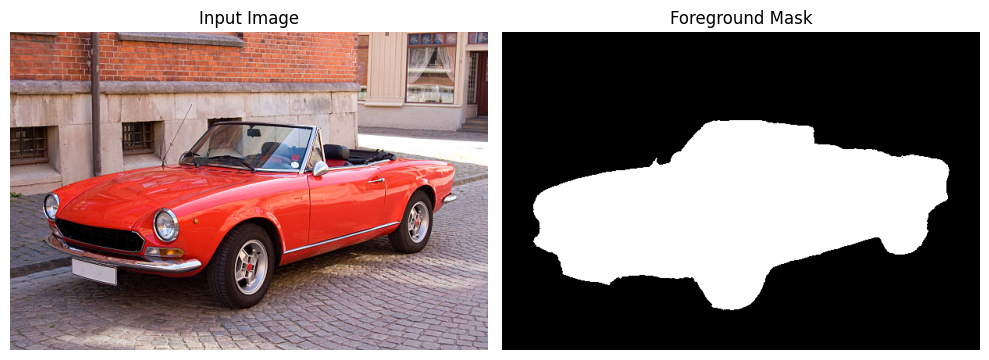

In [2]:
from transformers import pipeline
from PIL import Image
import requests
import matplotlib.pyplot as plt

segmentation_model = pipeline("image-segmentation", model="nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
image_url = "https://media.istockphoto.com/id/172303463/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%B8%D1%82%D0%B0%D0%BB%D1%8C%D1%8F%D0%BD%D1%81%D0%BA%D0%B8%D0%B9-%D0%BF%D0%B0%D1%83%D0%BA-%D1%81%D0%BF%D0%BE%D1%80%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9-%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C.jpg?s=612x612&w=0&k=20&c=VEzqGMTShSVpxQzdmvH2Z2IQ3CexNv5GuAHe1WWdeno="
input_image = Image.open(requests.get(image_url, stream=True).raw)
results = segmentation_model(input_image)
foreground_mask = results[-1]["mask"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis("off")
axes[1].imshow(foreground_mask, cmap="gray")
axes[1].set_title("Foreground Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Background Blur

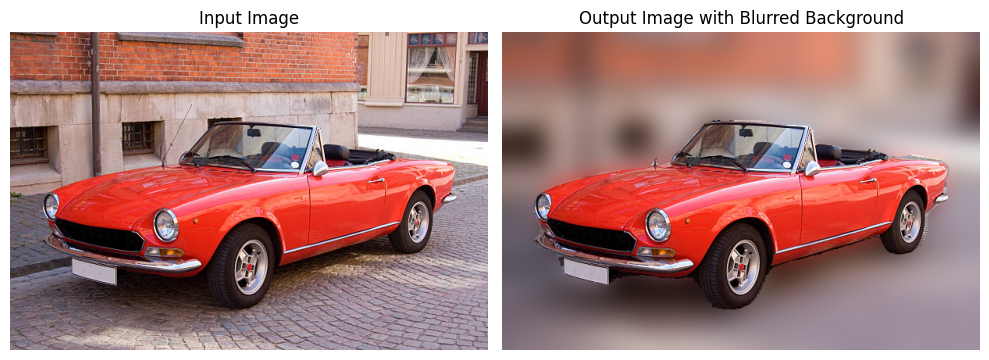

In [3]:
from PIL import ImageFilter

blurred_background = input_image.filter(ImageFilter.GaussianBlur(15))
output_image = Image.composite(input_image, blurred_background, foreground_mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(output_image)
axes[1].set_title("Output Image with Blurred Background")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Depth Map

config.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Device set to use cpu


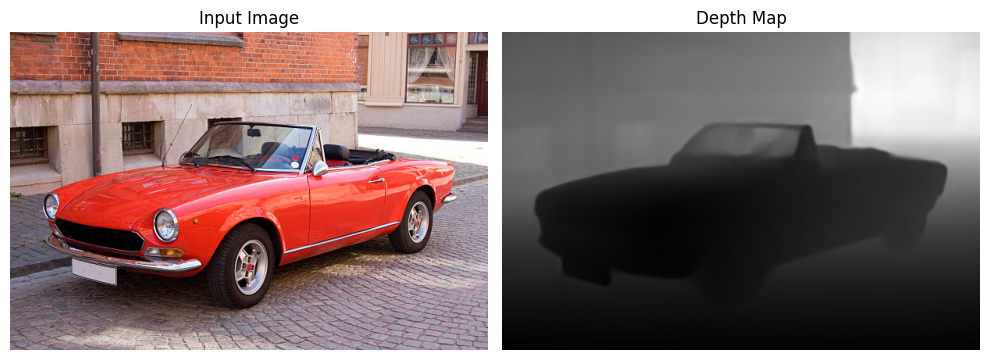

In [4]:
from transformers import pipeline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

depth_estimator = pipeline("depth-estimation", model="Intel/zoedepth-nyu-kitti")
depth_results = depth_estimator(input_image)
depth_map = depth_results["depth"]
depth_array = np.array(depth_map)
normalized_depth = (depth_array - np.min(depth_array)) / (np.max(depth_array) - np.min(depth_array))
img_array = np.array(input_image)

max_blur = 5.0
min_blur = 0.5
blurred_array = np.zeros_like(img_array, dtype=np.float32)

n_steps = 10
for i in range(n_steps):
    sigma = min_blur + (max_blur - min_blur) * i / (n_steps - 1)
    blurred_r = gaussian_filter(img_array[:,:,0], sigma=sigma)
    blurred_g = gaussian_filter(img_array[:,:,1], sigma=sigma)
    blurred_b = gaussian_filter(img_array[:,:,2], sigma=sigma)
    blurred_temp = np.stack([blurred_r, blurred_g, blurred_b], axis=2)

    lower_bound = i / n_steps
    upper_bound = (i + 1) / n_steps
    mask = (normalized_depth >= lower_bound) & (normalized_depth < upper_bound)
    mask = mask[..., np.newaxis]

    blurred_array = np.where(mask, blurred_temp, blurred_array)

blurred_image = Image.fromarray(blurred_array.astype('uint8'))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(depth_map, cmap="gray")
axes[1].set_title("Depth Map")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Variable Blur

Device set to use cpu


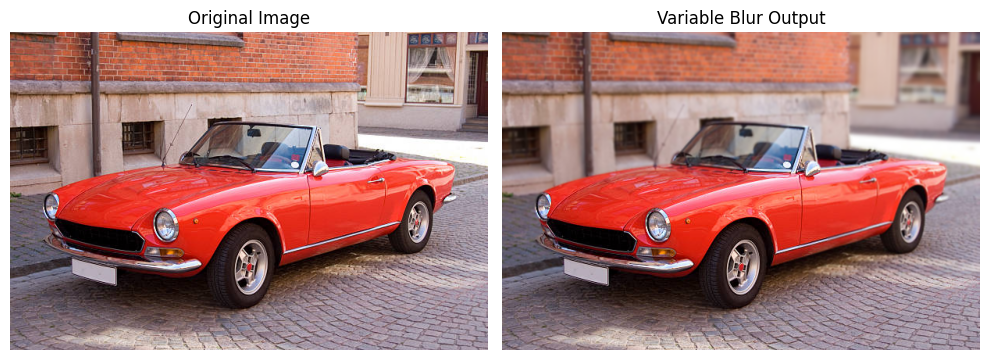

In [5]:
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

depth_estimator = pipeline("depth-estimation", model="Intel/zoedepth-nyu-kitti")
depth_results = depth_estimator(input_image)
depth_map = depth_results["depth"]

depth_array = np.array(depth_map)
normalized_depth = (depth_array - np.min(depth_array)) / (np.max(depth_array) - np.min(depth_array)) * 255

input_cv = np.array(input_image)
if input_cv.shape[-1] == 4:
    input_cv = input_cv[:, :, :3]
input_cv = cv2.cvtColor(input_cv, cv2.COLOR_RGB2BGR)
blurred_image = np.zeros_like(input_cv)
for x in range(input_cv.shape[1]):
    for y in range(input_cv.shape[0]):
        blur_intensity = int(normalized_depth[y, x] / 255 * 15)
        blur_intensity = max(1, blur_intensity // 2 * 2 + 1)
        blurred_pixel = cv2.GaussianBlur(input_cv, (blur_intensity, blur_intensity), 0)[y, x]
        blurred_image[y, x] = blurred_pixel

blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(blurred_image)
axes[1].set_title("Variable Blur Output")
axes[1].axis("off")

plt.tight_layout()
plt.show()